In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, t, chi2
from statsmodels.tsa.stattools import acf
from sklearn.metrics import *

In [ ]:
df=pd.read_csv('stock_mb.csv')

In [ ]:
df

,Date,Close
0,1/3/2023,15652.26
1,1/4/2023,15608.78
2,1/5/2023,15826.17
3,1/6/2023,15869.65
4,1/9/2023,15869.65
...,...,...
572,4/23/2025,23400.00
573,4/24/2025,23250.00
574,4/25/2025,23550.00
575,4/28/2025,23700.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    577 non-null    object 
 1   Close   577 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.1+ KB


In [ ]:
# convert date to datetime
df['Date']=pd.to_datetime(df['Date'])

In [ ]:
df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

In [ ]:
df

,Date,Close,Return
0,2023-01-03,15652.26,NaN
1,2023-01-04,15608.78,-0.002782
2,2023-01-05,15826.17,0.013831
3,2023-01-06,15869.65,0.002744
4,2023-01-09,15869.65,0.000000
...,...,...,...
572,2025-04-23,23400.00,0.012903
573,2025-04-24,23250.00,-0.006431
574,2025-04-25,23550.00,0.012821
575,2025-04-28,23700.00,0.006349


In [ ]:
df.dropna(inplace=True)

In [ ]:
# 3. Chia tập train/test
split_date = "2024-01-01"
train = df[df.Date < split_date]
test = df[df.Date >= split_date]

In [ ]:
train

,Date,Close,Return
1,2023-01-04,15608.78,-0.002782
2,2023-01-05,15826.17,0.013831
3,2023-01-06,15869.65,0.002744
4,2023-01-09,15869.65,0.000000
5,2023-01-10,15826.17,-0.002744
...,...,...,...
244,2023-12-25,16000.09,0.005450
245,2023-12-26,16043.57,0.002714
246,2023-12-27,16000.09,-0.002714
247,2023-12-28,16130.52,0.008119


In [ ]:
test

,Date,Close,Return
249,2024-01-02,16391.39,0.010667
250,2024-01-03,16652.27,0.015790
251,2024-01-04,17478.36,0.048417
252,2024-01-05,17826.19,0.019705
253,2024-01-08,18000.10,0.009709
...,...,...,...
572,2025-04-23,23400.00,0.012903
573,2025-04-24,23250.00,-0.006431
574,2025-04-25,23550.00,0.012821
575,2025-04-28,23700.00,0.006349


In [ ]:
# 4. Các hàm tính VaR
def var_parametric_normal(returns, alpha=0.01):
    mu = np.mean(returns)
    sigma = np.std(returns,ddof=1)
    return norm.ppf(alpha, mu, sigma)

def var_parametric_t(returns, alpha=0.01):
    df, loc, scale = t.fit(returns)
    return t.ppf(alpha, df, loc=loc, scale=scale)

def var_historical(returns, alpha=0.01):
    return np.quantile(returns, alpha)

In [ ]:
np.mean(train['Return'])

np.float64(0.00014304176355939784)

In [ ]:
# Tính VaR cố định từ tập train
var_norm = var_parametric_normal(train['Return'])
var_t = var_parametric_t(train['Return'])
var_hist = var_historical(train['Return'])

In [ ]:
var_norm, var_t, var_hist

(np.float64(-0.035508162928649945),
 np.float64(-0.04115749103600863),
 np.float64(-0.034065757933540435))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

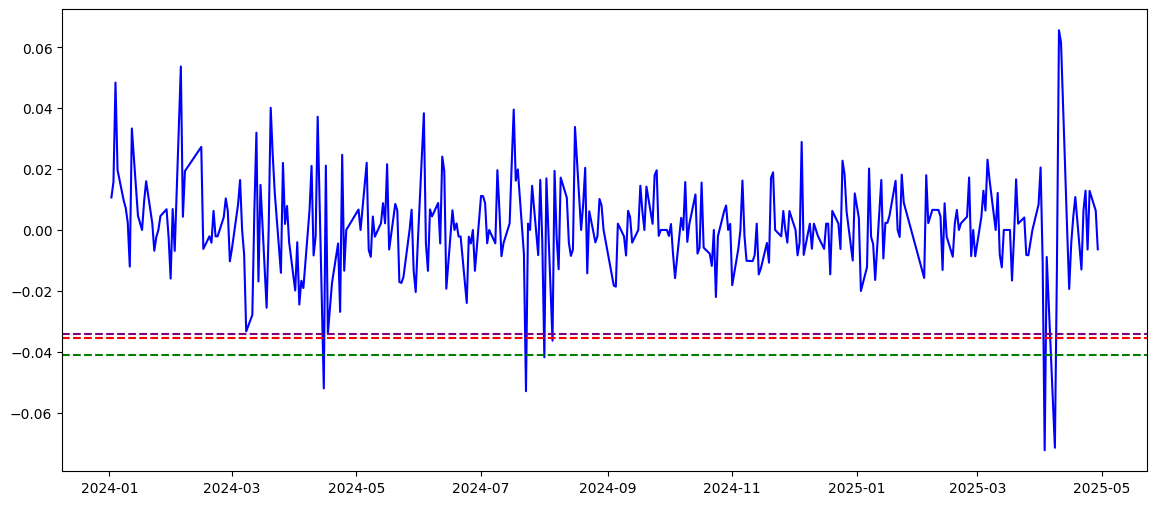

In [ ]:
# visualize results 3 var calculation methods
plt.figure(figsize=(14, 6))
plt.plot(test['Date'], test['Return'], label='Actual Return', color='blue')
plt.axhline(y=var_norm, color='red', linestyle='--', label=f'Parametric Normal VaR (99%)')
plt.axhline(y=var_t, color='green', linestyle='--', label=f'Parametric t-Student VaR (99%)')
plt.axhline(y=var_hist, color='purple', linestyle='--', label=f'Historical Simulation VaR (99%)')
plt


In [ ]:
# Hàm Backtesting
def backtest_var(test_returns, var_value):
    violations = test_returns < var_value
    vr = violations.sum() / len(test_returns)
    rmse = root_mean_squared_error([var_value]*len(test_returns), test_returns)
    mape = mean_absolute_percentage_error([var_value]*len(test_returns), test_returns)
    return violations, vr, rmse, mape

In [ ]:
# Backtest từng mô hình
violations_norm, vr_norm, rmse_norm, mape_norm = backtest_var(test['Return'], var_norm)
violations_t, vr_t, rmse_t, mape_t = backtest_var(test['Return'], var_t)
violations_hist, vr_hist, rmse_hist, mape_hist = backtest_var(test['Return'], var_hist)

In [ ]:
violations_norm.sum()

np.int64(6)

In [ ]:
vr_norm, vr_t, vr_hist

(np.float64(0.018292682926829267),
 np.float64(0.01524390243902439),
 np.float64(0.018292682926829267))

In [ ]:
# Chuẩn bị dữ liệu cho kiểm định Kupiec
def kupiec_test(violations, alpha=0.01):
    T = len(violations)
    x = violations.sum()
    p_hat = x / T
    LR = -2 * (np.log(((1 - alpha)**(T - x) * alpha**x)) - np.log(((1 - p_hat)**(T - x) * p_hat**x)))
    return LR

LR_kupiec_norm = kupiec_test(violations_norm)
LR_kupiec_t = kupiec_test(violations_t)
LR_kupiec_hist = kupiec_test(violations_hist)

# Tổng hợp kết quả
results = pd.DataFrame({
    'Model': ['Parametric Normal', 'Parametric t', 'Historical Simulation'],
    'VaR': [var_norm, var_t, var_hist],
    'VR': [vr_norm, vr_t, vr_hist],
    'RMSE': [rmse_norm, rmse_t, rmse_hist],
    'MAPE': [mape_norm, mape_t, mape_hist],
    'LR Kupiec': [LR_kupiec_norm, LR_kupiec_t, LR_kupiec_hist]
})

results

,Model,VaR,VR,RMSE,MAPE,LR Kupiec
0,Parametric Normal,-0.035508,0.018293,0.039919,1.051621,1.829840
1,Parametric t,-0.041157,0.015244,0.045161,1.040223,0.785072
2,Historical Simulation,-0.034066,0.018293,0.038599,1.055355,1.829840


In [ ]:
def conditional_coverage_test(violations):
    T = len(violations)
    # Chuyển thành chuỗi trạng thái 0 (không vi phạm) và 1 (vi phạm)
    v = violations.astype(int).values

    # Đếm số chuyển trạng thái:
    n00 = n01 = n10 = n11 = 0
    for i in range(1, T):
        if v[i-1] == 0 and v[i] == 0:
            n00 += 1
        elif v[i-1] == 0 and v[i] == 1:
            n01 += 1
        elif v[i-1] == 1 and v[i] == 0:
            n10 += 1
        elif v[i-1] == 1 and v[i] == 1:
            n11 += 1

    # Tổng số chuyển trạng thái
    n0 = n00 + n01
    n1 = n10 + n11
    epsilon = 1e-10  # Giá trị rất nhỏ để tránh log(0) hoặc chia 0

    pi0 = n01 / n0 if n0 > 0 else epsilon
    pi1 = n11 / n1 if n1 > 0 else epsilon
    pi = (n01 + n11) / (n0 + n1) if (n0 + n1) > 0 else epsilon

    # Tránh log(0) hoặc log(1)
    pi0 = np.clip(pi0, epsilon, 1 - epsilon)
    pi1 = np.clip(pi1, epsilon, 1 - epsilon)
    pi = np.clip(pi, epsilon, 1 - epsilon)


    # Thống kê kiểm định LRcc
    term1 = n00 * np.log(1 - pi0) + n01 * np.log(pi0) + n10 * np.log(1 - pi1) + n11 * np.log(pi1)
    term2 = (n00 + n10) * np.log(1 - pi) + (n01 + n11) * np.log(pi)
    LR_cc = -2 * (term2 - term1)
    return LR_cc


In [ ]:
LR_cc_norm = conditional_coverage_test(violations_norm)
LR_cc_t = conditional_coverage_test(violations_t)
LR_cc_hist = conditional_coverage_test(violations_hist)


In [ ]:
results['LR Conditional'] = [LR_cc_norm, LR_cc_t, LR_cc_hist]


In [ ]:
results

,Model,VaR,VR,RMSE,MAPE,LR Kupiec,LR Conditional
0,Parametric Normal,-0.035508,0.018293,0.039919,1.051621,1.829840,0.224312
1,Parametric t,-0.041157,0.015244,0.045161,1.040223,0.785072,0.155286
2,Historical Simulation,-0.034066,0.018293,0.038599,1.055355,1.829840,0.224312
